<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# Plot 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.title("Train vs Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

[MYCODE] 테스트 데이터 준비하기

In [ ]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

[MYCDOE] 배치사이즈 변경

- 배치 사이즈를 256으로 변경하여 학습시킨다.
234 = 60,000 / 256


In [16]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

[MYCODE] 테스트로더 만들기

In [17]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

[MYCODE] nn.CrossEntropyLoss 적용하기
- layer3 번째 활성 함수 삭제 최종 클래스 수를 10개로 지정하였습니다.

[FEEDBACK] 출력층의 레이어 활성함수 삭제

1. 세번째 출력층의 레이어에 활성함수를 두지 않는 근거를 어떻게 찾아야할까요?     
분류 문제이기 때문에 활성함수를 사용하지 않는다가 근거가 되는걸까요?

2. 출력 노드 수를 10개로 지정하는 기준은 예측해야하는가 아니면 하드코딩 방식으로만 가능할까요?     
예) 0~9가 10개 -> 노드의 수10개


In [18]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # 활성함수를 삭제
    return self.layer3(x)


model = Model(28 * 28, 1024).to('cuda')

[FEEDBACK] 학습률의 크기는 어떻게 정해지는가?

- 학습률의 크기는 현재 0.001이 보편적인 숫자인가요?


In [19]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

[MYCODE] nn.CrossEntropyLoss 적용하기

In [15]:
cretaition = nn.CrossEntropyLoss()

[LOG] 학습과정에서 에포크별 손실값, Train, Test 표시

In [20]:
n_epochs = 100

# Lists for Accuracy Tracking
train_accs = []
test_accs = []


for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    #print(f"모델 출력 크기: {preds.shape}")
    #print(f"모델 출력 값(샘플): {preds[0]}")

    assert labels.min() >= 0, "음수 값이 포함되어 있습니다!"
    assert labels.max() < 10, "클래스 개수를 초과합니다!"
    assert labels.dtype == torch.int64, "라벨 타입이 torch.LongTensor가 아닙니다!"

    loss = cretaition(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # Epoch 종료 후 정확도 계산
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss / len(trainloader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")



Epoch 1/100, Loss: 2.2934, Train Acc: 0.2265, Test Acc: 0.2334
Epoch 2/100, Loss: 2.2766, Train Acc: 0.3015, Test Acc: 0.3045
Epoch 3/100, Loss: 2.2592, Train Acc: 0.3539, Test Acc: 0.3572
Epoch 4/100, Loss: 2.2406, Train Acc: 0.4006, Test Acc: 0.4049
Epoch 5/100, Loss: 2.2204, Train Acc: 0.4548, Test Acc: 0.4579
Epoch 6/100, Loss: 2.1979, Train Acc: 0.5426, Test Acc: 0.5452
Epoch 7/100, Loss: 2.1727, Train Acc: 0.6033, Test Acc: 0.6044
Epoch 8/100, Loss: 2.1439, Train Acc: 0.6435, Test Acc: 0.6487
Epoch 9/100, Loss: 2.1111, Train Acc: 0.6743, Test Acc: 0.6762
Epoch 10/100, Loss: 2.0735, Train Acc: 0.6944, Test Acc: 0.6986
Epoch 11/100, Loss: 2.0304, Train Acc: 0.7090, Test Acc: 0.7135
Epoch 12/100, Loss: 1.9811, Train Acc: 0.7219, Test Acc: 0.7259
Epoch 13/100, Loss: 1.9250, Train Acc: 0.7308, Test Acc: 0.7360
Epoch 14/100, Loss: 1.8620, Train Acc: 0.7366, Test Acc: 0.7435
Epoch 15/100, Loss: 1.7921, Train Acc: 0.7420, Test Acc: 0.7489
Epoch 16/100, Loss: 1.7160, Train Acc: 0.7467, Te

[MYCODE] 정확도 PLOT 하기

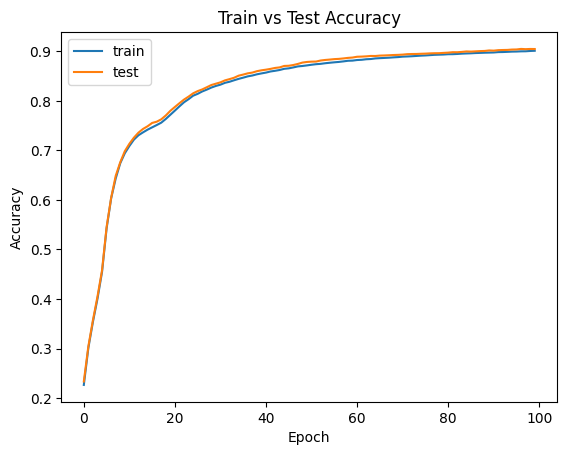

In [25]:
# 정확도 Plot
plot_acc(train_accs, test_accs)